In [1]:
# Tool
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display

from sklearn.model_selection import train_test_split

%matplotlib inline

# gitbub
# https://github.com/amueller/introduction_to_ml_with_python

# 6章 アルゴリズムチェーンとパイプライン

In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# データとロードして分割
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# 訓練データの最小値と最大値を計算
scaler = MinMaxScaler().fit(X_train)

In [3]:
# 訓練データをスケール変換
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# SVMをスケール変換したデータで訓練
svm.fit(X_train_scaled, y_train)
# テストデータをスケール変換して、それを用いて評価
X_test_scaled = scaler.transform(X_test)
print('Test score: {:.2f}'.format(svm.score(X_test_scaled, y_test)))

Test score: 0.95


C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## 6.1 前処理を行う際のパラメータ選択

In [4]:
from sklearn.model_selection import GridSearchCV
# 説明のためのコード。こんなふうに買いえてはNG
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10 ,100],
             'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print('Best cross.validation accuracy: {:.2f}'.format(grid.best_score_))
print('Best set score: {:.2f}'.format(grid.score(X_test_scaled, y_test)))
print('Best parameters:', grid.best_params_)

Best cross.validation accuracy: 0.98
Best set score: 0.97
Best parameters: {'C': 1, 'gamma': 1}


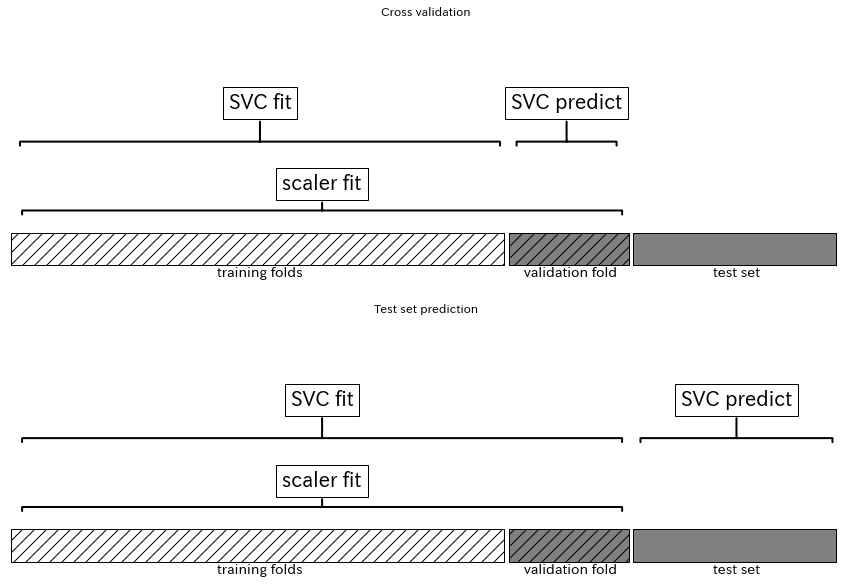

In [5]:
mglearn.plots.plot_improper_processing()

### 6.2  パイプラインの構築

In [6]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC())])

In [7]:
pipe.fit(X_train, y_train)

C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svm',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [8]:
print('Test score: {:.2f}'.format(pipe.score(X_test, y_test)))

Test score: 0.95


### 6-3 パイプラインを用いたグリッドサーチ

In [9]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
             'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [10]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print('Best corss-validation accuracy: {:.2f}'.format(grid.best_score_))
print('Test set score: {:.2f}'.format(grid.score(X_test, y_test)))
print('Best parameters: {}'.format(grid.best_params_))

Best corss-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


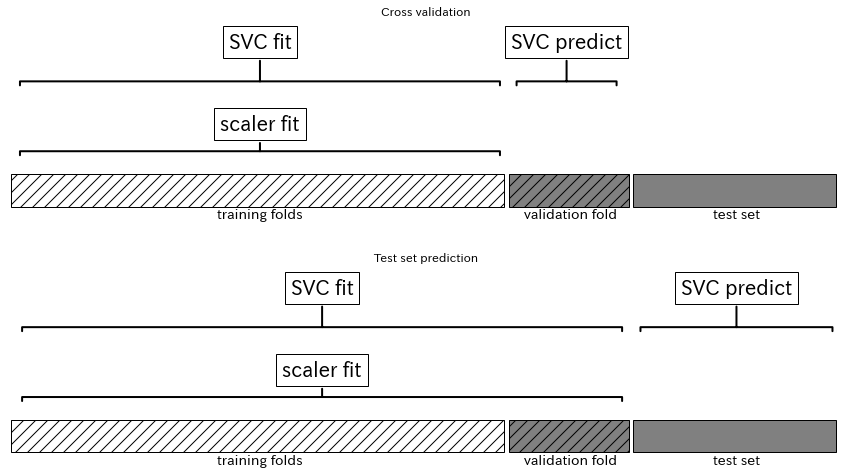

In [11]:
mglearn.plots.plot_proper_processing()

#### 情報リークの影響

In [12]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [13]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print('X_selected.shape: {}'.format(X_selected.shape))

X_selected.shape: (100, 500)


In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print('Cross-validaton accuracy (cv only on ridge): {:.2f}'.format(np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validaton accuracy (cv only on ridge): 0.91


In [15]:
pipe = Pipeline([('select', SelectPercentile(score_func=f_regression, percentile=5)),
                ('ridge', Ridge())])
print('Cross-validation accuracy (pipeline): {:.2f}'.format(np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


## 6.4 汎用パイプラインインターフェイス

In [16]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 最後のステップ以外でfitとtrainsformを順に実行
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 最後のステップでfit
    self.steps[-1][1].fit(X_trainsformed, y)
    return self

In [17]:
def predict(self, X):
    X_trainsformed = X
    for step in self.steps[:-1]:
        # 最後のステップ以外でfitとtrainsformを順に実行
        X_trasformed = step[1].transform(X_transformed)
    # 最後のステップではpredict
    return self.steps[-1][1].predict(X_trasformed)

### 6.4.1 make_pipelineによる簡便なパイプライン生成 

In [18]:
from sklearn.pipeline import make_pipeline
# 標準の文法
pipe_long = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC(C=100))])
# 短縮文法
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [19]:
print('Pipeline steps:\n{}'.format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False))]


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print('Pipeline steps:\n{}'.format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


### 6.4.2 ステップ属性へのアクセス

In [21]:
# cancerデータセットを用いて、定義しておいたパイプラインを訓練
pipe.fit(cancer.data)
# 'pca'ステップ2主成分を取り出す
components = pipe.named_steps['pca'].components_
print('components.shape: {}'.format(components.shape))

components.shape: (2, 30)


### 6.4.3 GridSearchCV内のパイプラインの属性へのアクセス

In [22]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [23]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [24]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                     

In [25]:
print('Best estimator:\n{}'.format(grid.best_estimator_))

Best estimator:
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


In [26]:
print('Logistic regression step:\n{}'.format(grid.best_estimator_.named_steps['logisticregression']))

Logistic regression step:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [27]:
print('Logistic regression coefficients:\n{}'.format(grid.best_estimator_.named_steps["logisticregression"].coef_))

Logistic regression coefficients:
[[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


### 6.5 前処理ステップとモデルパラメータに対するグリッドサーチ

In [28]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

In [29]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
             'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [30]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
         

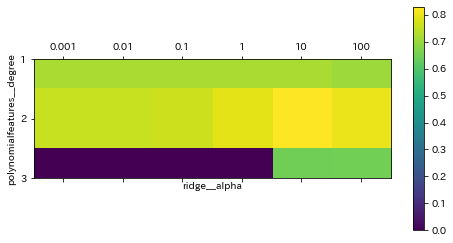

In [31]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1), vmin=0, cmap='viridis')
plt.xlabel('ridge__alpha')
plt.ylabel('polynomialfeatures__degree')
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
          param_grid['polynomialfeatures__degree'])
plt.colorbar()

In [32]:
print('Best parameters: {}'.format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [33]:
print('Test-set score: {:.2f}'.format(grid.score(X_test, y_test)))

Test-set score: 0.77


In [34]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print('Score without poly features: {:.2f}'.format(grid.score(X_test, y_test)))

Score without poly features: 0.63


C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 6.6 グリッドサーチによるモデルの選択

In [35]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [36]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
    'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
    'preprocessing': [None], 'classifier__max_features':[1, 2, 3]}]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print('Best param:\n{}\n'.format(grid.best_params_))
print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
print('Test-set score: {:.2f}'.format(grid.score(X_test, y_test)))

Best param:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.99
Test-set score: 0.98


# 7章 テキストデータの処理

In [2]:
from sklearn.datasets import load_files

reviews_train = load_files('data/aclImdb/train/')

In [3]:
# load_filesは一連の訓練テキストと訓練ラベルを返す
text_train, y_train = reviews_train.data, reviews_train.target
print('type of text_train: {}'.format(type(text_train)))
print('length of text_train: {}'.format(len(text_train)))
print('text_tarin[1]:\n{}'.format(text_train[1]))

type of text_train: <class 'list'>
length of text_train: 25000
text_tarin[1]:
b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decisio

In [4]:
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

In [5]:
print("Samples per class (training): {}".format(np.bincount(y_train)))

Samples per class (training): [12500 12500]


In [6]:
# testデータもロード
reviews_test = load_files('data/aclImdb/test/')
text_test, y_test = reviews_test.data, reviews_test.target
print('Numver of decuments in test data: {}'.format(len(text_test)))
print('Samples per class (test): {}'.format(np.bincount(y_test)))
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

Numver of decuments in test data: 25000
Samples per class (test): [12500 12500]


## 7.3 Bag of Wordsによるテキスト表現

#### 7.3.1 トイデータセットに対するBow

In [7]:
bards_words = ['The fool doth think he is wise,',
              'but the wise man knows himself to be a fool']

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [9]:
print('Vocabulary size: {}'.format(len(vect.vocabulary_)))
print('Vocabulary content:\n {}'.format(vect.vocabulary_))

Vocabulary size: 13
Vocabulary content:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [10]:
bag_of_words = vect.transform(bards_words)
print('bag_of_words: {}'.format(repr(bag_of_words)))

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


In [11]:
print('Dense representation of bag_of_words:\n{}'.format(bag_of_words.toarray()))

Dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


## 7.3.2 映画レビューのBow

In [12]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print('X_train:\n{}'.format(repr(X_train)))

X_train:
<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


In [13]:
feature_names = vect.get_feature_names()
print('Number of features:{}'.format(len(feature_names)))
print('First 20 features:\n{}'.format(feature_names[:20]))
print('Features 20010 to 20030:\n{}'.format(feature_names[20010:20030]))
print('Every 2000th feature:\{}'.format(feature_names[::2000]))

Number of features:74849
First 20 features:
['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02']
Features 20010 to 20030:
['dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers', 'drawing', 'drawings', 'drawl', 'drawled', 'drawling', 'drawn', 'draws', 'draza', 'dre', 'drea']
Every 2000th feature:\['00', 'aesir', 'aquarian', 'barking', 'blustering', 'bête', 'chicanery', 'condensing', 'cunning', 'detox', 'draper', 'enshrined', 'favorit', 'freezer', 'goldman', 'hasan', 'huitieme', 'intelligible', 'kantrowitz', 'lawful', 'maars', 'megalunged', 'mostey', 'norrland', 'padilla', 'pincher', 'promisingly', 'receptionist', 'rivals', 'schnaas', 'shunning', 'sparse', 'subset', 'temptations', 'treatises', 'unproven', 'walkman', 'xylophonist']


In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print('Mean corss-validation accuracy: {:.2f}'.format(np.mean(scores)))

C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean corss-validation accuracy: 0.88


In [15]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ',grid.best_params_)

C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best cross-validation score: 0.89
Best parameters:  {'C': 0.1}


In [16]:
X_test = vect.transform(text_test)
print('{:.2f}'.format(grid.score(X_test, y_test)))

0.88


In [17]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print('X_train with min_df: {}'.format(repr(X_train)))

X_train with min_df: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


In [18]:
feature_names = vect.get_feature_names()

print('First 50 features:\n{}'.format(feature_names[:50]))
print('Features 20010 to 20030:\n{}'.format(feature_names[20010:20030]))
print('Every 700th feature:\n{}'.format(feature_names[::700]))

First 50 features:
['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103', '104', '105', '107', '108', '10s', '10th', '11', '110', '112', '116', '117', '11th', '12', '120', '12th', '13', '135', '13th', '14', '140', '14th', '15', '150', '15th', '16', '160', '1600', '16mm', '16s', '16th']
Features 20010 to 20030:
['repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete', 'replica']
Every 700th feature:
['00', 'affections', 'appropriately', 'barbra', 'blurbs', 'butchered', 'cheese', 'commitment', 'courts', 'deconstructed', 'disgraceful', 'dvds', 'eschews', 'fell', 'freezer', 'goriest', 'hauser', 'hungary', 'insinuate', 'juggle', 'leering', 'maelstrom', 'messiah', 'music', 'occasional', 'parking', 'pleasantville', 'pronunciati

In [19]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print('Best cross-validation score: {:.2f}'.format(grid.best_score_))

C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best cross-validation score: 0.89


## 7.4 ストップワード

In [20]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print('Number of stop words: {}'.format(len(ENGLISH_STOP_WORDS)))
print('Every 10th stopword:\n{}'.format(list(ENGLISH_STOP_WORDS)[::10]))

Number of stop words: 318
Every 10th stopword:
['part', 'herein', 'also', 'at', 'whereby', 'any', 'whereupon', 'twenty', 'much', 'whether', 'whole', 'eight', 'ours', 'more', 'de', 'move', 'this', 'from', 'several', 'as', 'alone', 'per', 'between', 'whither', 'during', 'almost', 'beforehand', 'why', 'everywhere', 'us', 'two', 'noone']


In [21]:
# stop_words='english'を指定すると、組み込みのストップワードリストを用いる
# ストップワードリストに単語を追加したり、独自のものを使うことも出来る
vect = CountVectorizer(min_df=5, stop_words='english').fit(text_train)
X_train = vect.transform(text_train)
print('X_train with stop words:\n{}'.format(repr(X_train)))

X_train with stop words:
<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


In [22]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print('Best cross-validation score: {:.2f}'.format(grid.best_score_))

C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best cross-validation score: 0.88


## 7.5 tf-idfを用いたデータのスケール変換

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Best cross-validation score: 0.89


In [24]:
vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']
# 訓練データセットを変換
X_train = vectorizer.transform(text_train)
# それぞれの特徴量のデータセット中での最大値を見つける
max_value = X_train.max(axis=0).toarray().ravel()
sorted_byidf = max_value.argsort()
# 特徴量名を取得
feature_names = np.array(vectorizer.get_feature_names())

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_byidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_byidf[-20:]]))

Features with lowest tfidf:
['poignant' 'disagree' 'instantly' 'importantly' 'lacked' 'occurred'
 'currently' 'altogether' 'nearby' 'undoubtedly' 'directs' 'fond'
 'stinker' 'avoided' 'emphasis' 'commented' 'disappoint' 'realizing'
 'downhill' 'inane']
Features with highest tfidf: 
['coop' 'homer' 'dillinger' 'hackenstein' 'gadget' 'taker' 'macarthur'
 'vargas' 'jesse' 'basket' 'dominick' 'the' 'victor' 'bridget' 'victoria'
 'khouri' 'zizek' 'rob' 'timon' 'titanic']


In [25]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print('Features with lowest idf:\n{}'.format(feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


## 7.6 モデル係数の調査

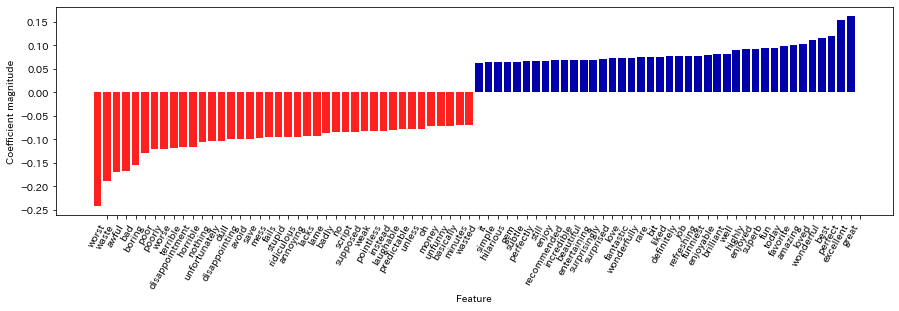

In [26]:
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps['logisticregression'].coef_, feature_names, n_top_features=40)

## 7.7 1単語よりも大きい単語のBag-of-Words(n-グラム)

In [28]:
print('bards_words:\n{}'.format(bards_words))

bards_words:
['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


In [31]:
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print('Vocabulary size: {}'.format(len(cv.vocabulary_)))
print('Vocabulary:\n{}'.format(cv.get_feature_names()))

Vocabulary size: 13
Vocabulary:
['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


In [32]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print('Vocabulary size: {}'.format(len(cv.vocabulary_)))
print('Vocabulary:\n{}'.format(cv.get_feature_names()))

Vocabulary size: 14
Vocabulary:
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


In [ ]:
print('Transformed data (dense):\n{}'.format(cv.transform(bards_words).toarry()))

In [33]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print('Vocabulary size: {}'.format(len(cv.vocabulary_)))
print('Vocabulary:\n{}'.format(cv.get_feature_names()))

Vocabulary size: 39
Vocabulary:
['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


In [37]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression())
# グリッドが比較的大きい上、トリグラムが含まれているのでこのグリッドサーチの実行にはかなり時間がかかる
param_grid = {'logisticregression__C':[0.001, 0.01, 0.1, 1, 10, 100],
             'tfidfvectorizer__ngram_range':[(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters:\n{}'.format(grid.best_params_))

C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mikam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Best cross-validation score: 0.91
Best parameters:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


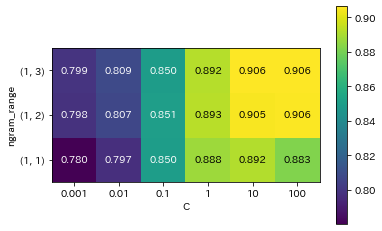

In [39]:
# グリッドサーチのスコアを取り出す
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# ヒートマップとして可視化
heatmap = mglearn.tools.heatmap(scores, xlabel='C', ylabel='ngram_range', cmap='viridis', fmt='%.3f',
                               xticklabels=param_grid['logisticregression__C'],
                               yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

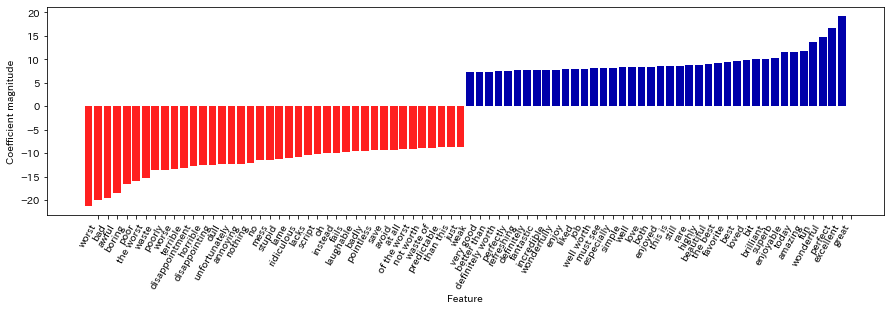

In [40]:
# 特徴量の名前と係数を取り出す
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)

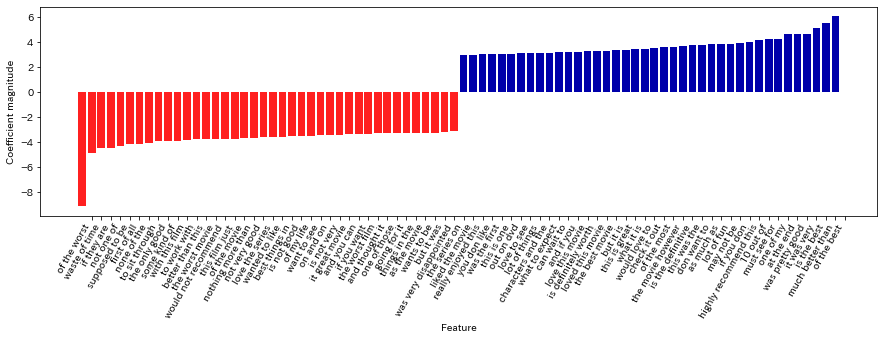

In [42]:
# トリグラム特徴量を見つける
mask = np.array([len(feature.split(' ')) for feature in feature_names]) == 3
# トリグラム特徴量だけを可視化
mglearn.tools.visualize_coefficients(coef.ravel()[mask],
                                    feature_names[mask], n_top_features=40)

## 7.8 より進んだトークン分割、語幹処理、見出し語化

In [43]:
import spacy
import nltk

# spacyの英語モデルをロード
e_nlp = spacy.load('en')
# nltkのPorter stemmerのインスタンスを作成
stemmer = nltk.stem.PorterStemmer()

# spacyによる見出し語化とnltkによる語幹処理を比較する関数を定義
def compare_normalization(doc):
    # spacyで文書をトークン処理
    doc_spacy = en_nlp(doc)
    # spacyで見つけた見出し語を表示
    print('Lemmatization:')
    print('[token.lemma_ for token in doc_spacy]')
    # Porter stemmerで見つけたトークンを表示
    print('Stemming:')
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

ModuleNotFoundError: No module named 'spacy'

In [ ]:
compare_normalization(u"Our meeting today was worse than yesterday,"
                     "I'm scared of meeting the clients tomorrow.")

In [ ]:
# 技術的詳細：CountVectorizerが用いている正規表現ベースのトークン分割を用いて、見出し言語だけにspacyを用いるのが望ましい
# このため、en_nlp.tokenizer(spacyのトークン分割器)を正規表現ベースのトークン分割器に置き換えている
import re
# CountVectorizerで用いられるトークン分割用の正規表現
# regexp used in CountVectorizer
regexp = re.compile('(?u)\\b\w\\w+\\b')

# spacyの言語モデルを読み込み、トークン分割器を取り出す
en_nlp = spacy.load('en')
old_tokenzizer = en_nlp.tokenizer
# トークン分割器を先ほどの正規表現で置き換える
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(regexp.findall(string))

# spacyの文書処理パイプラインを用いてカスタムトークン分割器を作る
# (正規表現を用いたトークン分割器を組み込んである)
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

# CountVectorizerをカスタムトークン分割器を使って定義する
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)

In [ ]:
# 見出し語化を行う CountVectorizerでtext_trainを変換
X_train_lemma = lemma_vect.fit_transform(text_train)
print('X_train_lemma.shape: {}'.format(X_train_lemma.shape))

# 比較の為に標準のCountVectorizerでも変換
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.trans(text_train)
print('X_train.shape: {}'.format(X_train.shape))

In [ ]:
# データの1%だけを訓練セットとして用いてグリッドサーチを行う
from sklearn.model_selection import StratifiedShuffleSplit

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.99, train_size=0.01, random_state=0)
grid = GridSearchCV(LogisticRegression(), param_grid, cv=cv)
# 標準のCountVectorizerを用いてグリッドサーチを実行
grid.fit(X_train, y_train)
print('Best cross-validation score'
     "(Standard CountVectorizer): {:.3f}".format(grid.best_score_))
# 見出し語付きでグリッドサーチを実行
grid.fit(X_train_lemma, y_train)
print('Best cross-validation score'
     "(lemmatization): {:.3f}".format(grid.best_score_))
#

## 7.9 トピッククスモデリングと文書クラスタリング

### LDA(Latent Dirichlet Allocation)

In [44]:
vecct = CountVectorizer(max_features=1000, max_df=.15)
X = vect.fit_transform(text_train)

In [49]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
                                max_iter=25, random_state=0)

# ここではモデルの構築と変換を一度に行う
# 変換には時間がかかるが、同時に行うことで時間を節約することができる
document_topics = lda.fit_transform(X)

In [50]:
lda.components_.shape

(10, 250467)

In [51]:
# それぞれのトピック(components_の行)に対して、特徴量を昇順でソート
# ソートを降順にするために[:, ::-1]で行を反転
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# vectorizerから特徴量名を取得
feature_names = np.array(vect.get_feature_names())

In [52]:
# 最初の10トピックを表示
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                          sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
curly sue     behave the waydin           shapiro       newcombe      
smallville    behave the    rukh          ken shapiro   pintilie      
episode of smallvilleit terrible itcarla         peter lyman   tas           
movie yesterdayso fake that  gunga         putting all myschneebaum    
this movie yesterdayridiculously stupidgunga din     all my eggs   bathhouse     
of smallville someone it    norris        my eggs       presque rien  
de vierde     fake that it  travolta      my eggs in    presque       
de vierde man thought hey   visconti      eggs in one   mikels        
it love it    please people wwe           eggs in       joke if       
et la putain  watching it whenhanzo         in one basket rivers and tides


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------  

In [53]:
lda = LatentDirichletAllocation(n_components=100, learning_method="batch",
                                max_iter=25, random_state=0)
document_topics = lda.fit_transform(X)

In [54]:
topics = np.array([7, 16, 24, 25, 28, 36, 37, 45, 51, 53, 54, 63, 89, 97])

sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
mglearn.tools.print_topics(topics=topics, feature_names=feature_names,
                          sorting=sorting, topics_per_chunk=7, n_words=20)

topic 7       topic 16      topic 24      topic 25      topic 28      topic 36      topic 37      
--------      --------      --------      --------      --------      --------      --------      
astaire       shaolin       bourne        macarthur     700           tarzan        summer of     
winchester    classed       seagal        meryl streep  spit on       tarzan and    the summer of 
mann          shaolin templemildred       streep        were lot of   in favor      luthor        
stewart       in lifetime   the chemistry meryl         there were lotfavor of      lex           
granger       once in lifetimetimon         cheadle       your grave    in favor of   lex luthor    
winchester 73 music industry1940          dillinger     spit on your  wagner        ewan mcgregor 
rifle         nothing going forandrew        hilliard      on your grave weissmuller   lois          
james stewart nothing going they come     reign         ways than     soft core pornin the summer 
astai

In [56]:
# "音楽関連"トピック45に対する重みでソート
music = np.argsort(document_topics[:, 45])[::-1]
# このトピックを最も重要としている５つの文書を表示
for i in music[:10]:
    # 最初の2文字を表示
    print(b'.'.join(text_train[i].split(b'.')[:2]) + b'.\n')

b'Helena Bonham Carter is the center of this movie. She plays her role almost immobile in a wheelchair but still brings across her traditional intensity.\n'
b"Sudden Impact is the best of the five Dirty Harry movies. They don't come any leaner and meaner than this as Harry romps through a series of violent clashes, with the bad guys getting their just desserts.\n"
b'Red Skelton was still another major star who made the transition from movies to television with ease.  His shows certainly brought a laughter to the American households of years back.\n'
b'Red Skelton was still another major star who made the transition from movies to television with ease.  His shows certainly brought a laughter to the American households of years back.\n'
b'Very heart warming and uplifting movie. Outstanding performance by Alisan Porter (Curly Sue).\n'
b"A dreary, hopelessly predictable film set in a most unpleasant setting (lower Coachella Valley). Acting is as amateurish as any I've seen.\n"
b'I know a f

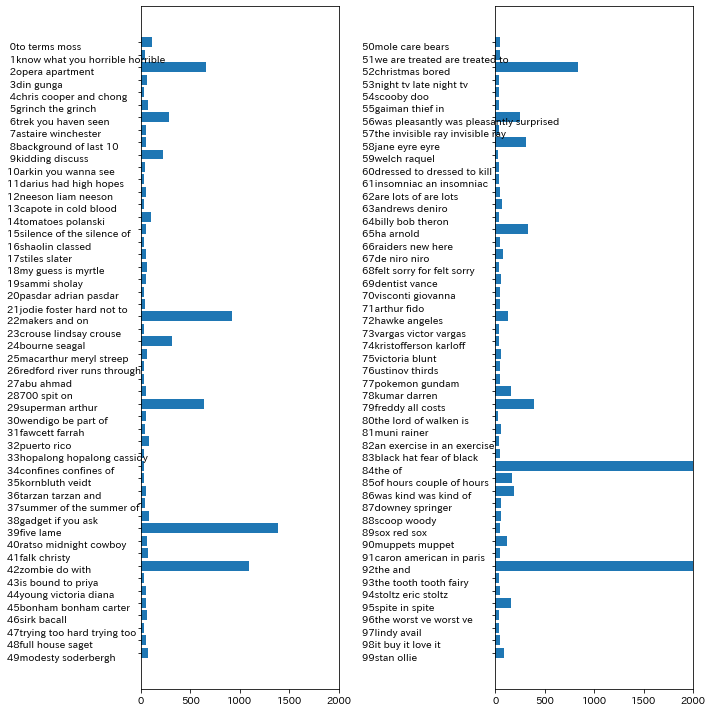

In [58]:
fig , ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ['{:>2}'.format(i) + ' '.join(words) for i, words in enumerate(feature_names[sorting[:, :2]])]

# 2カラムの棒グラフ
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha='left', va='top')
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()    